In [2]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys 
sys.path.insert(1, '../')
from config import file_path_10million_rows_csv, file_path_1million_rows_csv

FILE_PATH = file_path_10million_rows_csv
FILE_PATH_2 = file_path_1million_rows_csv

In [3]:
def read_polars(file_path):
    '''
    Read a csv with polars
    '''
    df = pl.scan_csv(file_path).collect()
    return df

def read_pandas(file_path):
    '''
    Read a csv file with pandas
    '''
    df = pd.read_csv(file_path)
    return df

def agg_polars(pl_df):
    '''
    take a polars df and execute a few aggregate functions
    '''
    q = (
        pl_df.lazy()
        .groupby('state')
        .agg(
            [
                pl.count().alias('cnt'),
                pl.col('age').mean().alias('mean age'),
                pl.col('age').min().alias('min age'),
                pl.col('age').max().alias('max age')
            ]
        )
        .sort('state')
    )

    output = q.collect()
    
    return output

def agg_pandas(pd_df):
    '''
    take a pandas df and execute a few aggregate functions
    '''
    output = (
        pd_df
        .groupby('state')['age']
        .agg(            
            ['count', 'mean', 'min', 'max'],    
        )
        .sort_values(by=['state'])
    )

    return output

def window_func_polars(pl_df):
    '''
    new column 1 - avg age per state
    new column 2 - age rank within each state
    '''
    q = (
        pl_df.lazy()
        .select(
            [
                'email',
                'first',
                'last',
                'state',
                'age'
            ]
        )
        .with_columns([
            pl.col('age').mean().over('state').alias('avg_age_per_state'),
            pl.col('age').rank(method='dense').over('state').alias('age_rank')
        ])
        .sort('state')
    )

    output = q.collect()

    return output

def window_func_pandas(pd_df):
    '''
    new column 1 - avg age per state
    new column 2 - age rank within each state
    '''
    output = (
        pd_df
        .loc[:, ['email', 'first', 'last', 'state', 'age']]
        .assign(avg_age_per_state=lambda df: df.groupby('state')['age'].transform('mean'))
        .assign(age_rank=lambda df: df.groupby('state')['age'].rank(method='dense'))
        .sort_values(by=['state'])
    )
    
    return output

def join_polars(pl_df1, pl_df2, on_column, join_type):
    '''
    a func to join in polars based on inputs
    '''
    output = pl_df1.lazy().join(pl_df2.lazy(), on=on_column, how=join_type).collect()
    return output

def join_pandas(pd_df1, pd_df2, on_column, join_type):
    '''
    a func to join in pandas based on inputs
    '''
    output = pd_df1.merge(pd_df2, on=on_column, how=join_type)
    return output

def time_a_function(func, *args):
    '''
    A func to time a function
    '''
    start_time = time.time()
    func(*args)
    end_time = time.time()
    result = round(end_time - start_time, 2)
    return result

def test_pandas_vs_polars(pl_func, pd_func, pl_func_params, pd_func_params):
    '''
    testing performance on pandas func vs polars func
    '''
    pl_time = time_a_function(pl_func, *pl_func_params)
    print(f'Polars took {pl_time} seconds.')
    pd_time = time_a_function(pd_func, *pd_func_params)
    print(f'Pandas took {pd_time} seconds.')
    
    return pl_time, pd_time


In [4]:
#  preapre dfs
pl_df1 = read_polars(FILE_PATH)
pl_df2 = read_polars(FILE_PATH_2)
pd_df1 = read_pandas(FILE_PATH)
pd_df2 = read_pandas(FILE_PATH_2)


In [5]:
##### read a csv file #####
print('Reading 10 million rows with 14 columns (1.2GB)...')
pl_read_csv_time, pd_read_csv_time = test_pandas_vs_polars(read_polars, read_pandas, [FILE_PATH], [FILE_PATH])

Reading 10 million rows with 14 columns (1.2GB)...
Polars took 5.51 seconds.
Pandas took 65.64 seconds.


In [6]:
##### simple aggregations #####
print('\nTesting performance on aggregations...')
pl_agg_time, pd_agg_time = test_pandas_vs_polars(agg_polars, agg_pandas, [pl_df1], [pd_df1])

##### window functions #####
print('\nTesting performance on window functions...')
pl_window_time, pd_window_time = test_pandas_vs_polars(window_func_polars, window_func_pandas, [pl_df1], [pd_df1])

##### join operations #####
print('\nTesting performance on joins...')

print('--- Inner join --- ')
pl_inner_join_time, pd_inner_join_time = test_pandas_vs_polars(join_polars, join_pandas, [pl_df1, pl_df2, 'email', 'inner'], [pd_df1, pd_df2, 'email', 'inner'])

print('--- Left outer join ---')
pl_left_join_time, pd_left_join_time = test_pandas_vs_polars(join_polars, join_pandas, [pl_df1, pl_df2, 'email', 'left'], [pd_df1, pd_df2, 'email', 'left'])

print('--- Full outer join ---')
pl_full_join_time, pd_full_join_time = test_pandas_vs_polars(join_polars, join_pandas, [pl_df1, pl_df2, 'email', 'outer'], [pd_df1, pd_df2, 'email', 'outer'])



Testing performance on aggregations...
Polars took 0.61 seconds.
Pandas took 1.04 seconds.

Testing performance on window functions...
Polars took 4.59 seconds.
Pandas took 36.4 seconds.

Testing performance on joins...
--- Inner join --- 
Polars took 1.42 seconds.
Pandas took 15.06 seconds.
--- Left outer join ---
Polars took 3.39 seconds.
Pandas took 34.33 seconds.
--- Full outer join ---
Polars took 5.2 seconds.
Pandas took 36.58 seconds.


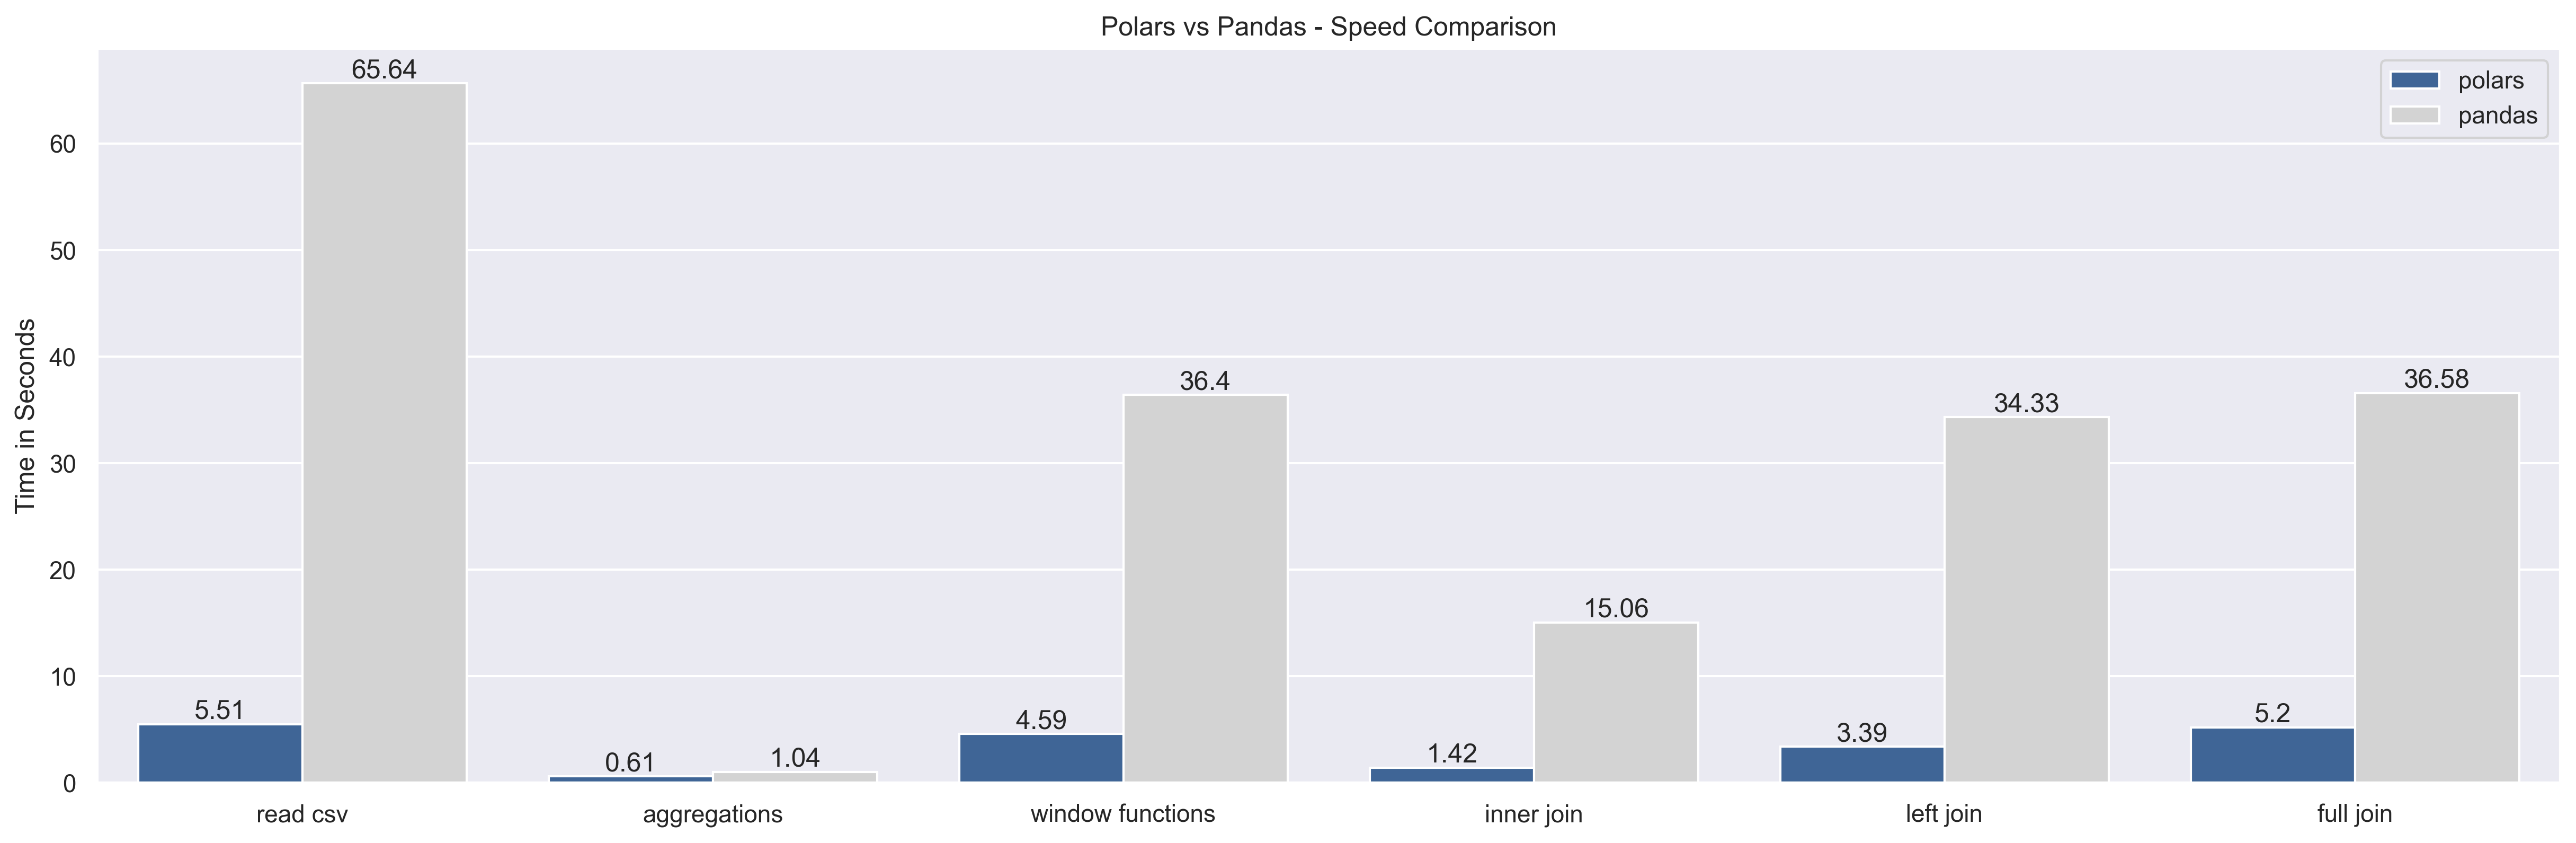

In [13]:
##### visualize result #####

sns.set(rc={'figure.dpi':300, 'savefig.dpi':300})
sns.set_style(style=None)

data = [
    # polars
    [pl_read_csv_time, 'read csv', 'polars'], 
    [pl_agg_time, 'aggregations', 'polars'],
    [pl_window_time, 'window functions', 'polars'],
    [pl_inner_join_time, 'inner join', 'polars'],
    [pl_left_join_time, 'left join', 'polars'],
    [pl_full_join_time, 'full join', 'polars'],
    # pandas
    [pd_read_csv_time, 'read csv', 'pandas'], 
    [pd_agg_time, 'aggregations', 'pandas'],
    [pd_window_time, 'window functions', 'pandas'],
    [pd_inner_join_time, 'inner join', 'pandas'],
    [pd_left_join_time, 'left join', 'pandas'],
    [pd_full_join_time, 'full join', 'pandas'],
]

df = pl.DataFrame(data, schema=['time in seconds', 'test type', 'library'])

plt.figure(figsize=(20, 6))
ax = sns.barplot(x=list(df['test type']), y=list(df['time in seconds']), hue=list(df['library']), errorbar=None, palette=['#3063A5', '#d3d3d3'])

# adding labels
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel='', ylabel='Time in Seconds')
plt.title('Polars vs Pandas - Speed Comparison')
plt.show()

fig = ax.get_figure()
fig.savefig('polars vs pandas - jupyter notebook.png') 
